In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score



import kagglehub

# Download latest version
path = kagglehub.dataset_download("dharun4772/doordash-eta-prediction")



100%|██████████| 4.99M/4.99M [00:00<00:00, 61.0MB/s]

Extracting files...


#Check-in #1


In [ ]:
# Link to dataset of doordash deliveries: https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction/data
print(os.listdir(os.getcwd()))
path = kagglehub.dataset_download('dharun4772/doordash-eta-prediction')

# Construct the full path to the 'historical_data.csv' file within the downloaded directory
csv_file_path = os.path.join(path, 'historical_data.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
df.head()


['.config', 'sample_data']


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [ ]:
df = pd.read_csv(csv_file_path)
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


We’re working with a DoorDash dataset to predict food delivery times. The goal is to build a model that accurately estimates how long it takes from when an order is placed to when it's delivered. The data includes features like order details (number of items, subtotal), restaurant info, and market conditions (available dashers, outstanding orders). We also have timestamps for when the order was placed and delivered, which helps us calculate the delivery time.

In [ ]:
df.head(10)
# Our response variable is going to be the datetime difference between actual_delivery_time and created_at

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0


We’re choosing the following features because they directly impact the complexity and timing of the delivery process:
*   total_items: More items in an order can lead to longer preparation and packaging times, which can delay the delivery.
*   num_distinct_items: A higher number of distinct items may require more coordination in the kitchen, increasing the order complexity and affecting delivery time.
total_onshift_dashers: The number of available dashers influences how
*   total_onshift_dashers: The number of available dashers influences how quickly an order can be assigned and delivered. More available dashers typically result in faster deliveries.
*   total_busy_dashers: If many dashers are already working on other orders, it can create delays in assigning a dasher to a new order, impacting delivery time.

In [ ]:
# Convert 'actual_delivery_time' and 'created_at' to datetime objects
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate the difference in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

In [ ]:
df.head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333
5,3.0,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,38.333333
6,3.0,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,26.400000
7,3.0,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,32.750000
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
9,3.0,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,53.200000


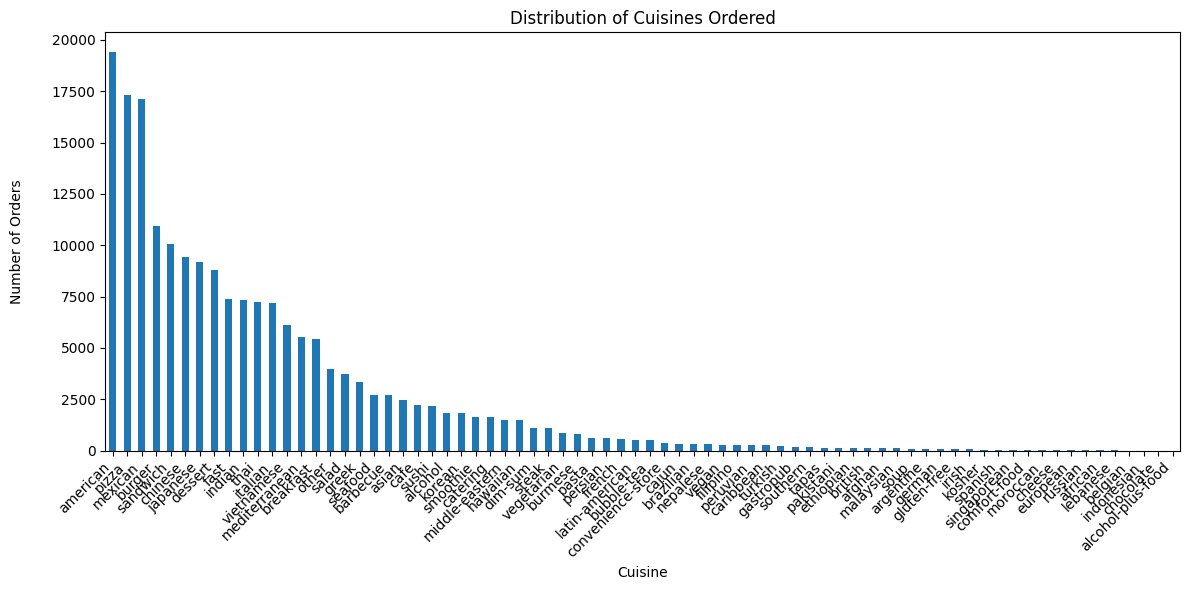

In [ ]:
plt.figure(figsize=(12, 6))
df['store_primary_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Cuisines Ordered')
plt.xlabel('Cuisine')
plt.ylabel('Number of Orders', labelpad=20)  # Increase label padding
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Count the number of nans in the 'store_primary_category' column
nan_count = df['store_primary_category'].isna().sum()
print(f"Number of NaNs in 'store_primary_category': {nan_count}")

# Drop rows with nans in 'store_primary_category'
df = df.dropna(subset=['store_primary_category'])

Number of NaNs in 'store_primary_category': 4760


In [ ]:
df.head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
14,1.0,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,37.883333
15,1.0,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,49.800000
16,1.0,2841,italian,1.0,3,4475,3,925,1825,4.0,1.0,1.0,446,542.0,87.783333
17,1.0,2841,italian,1.0,3,4375,3,1325,1625,6.0,4.0,3.0,446,789.0,82.933333
18,1.0,2841,italian,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,446,548.0,71.600000
19,1.0,4139,mexican,1.0,2,950,2,150,700,24.0,24.0,26.0,446,212.0,50.316667
20,1.0,4139,mexican,1.0,5,1285,3,150,400,12.0,13.0,11.0,446,424.0,28.883333


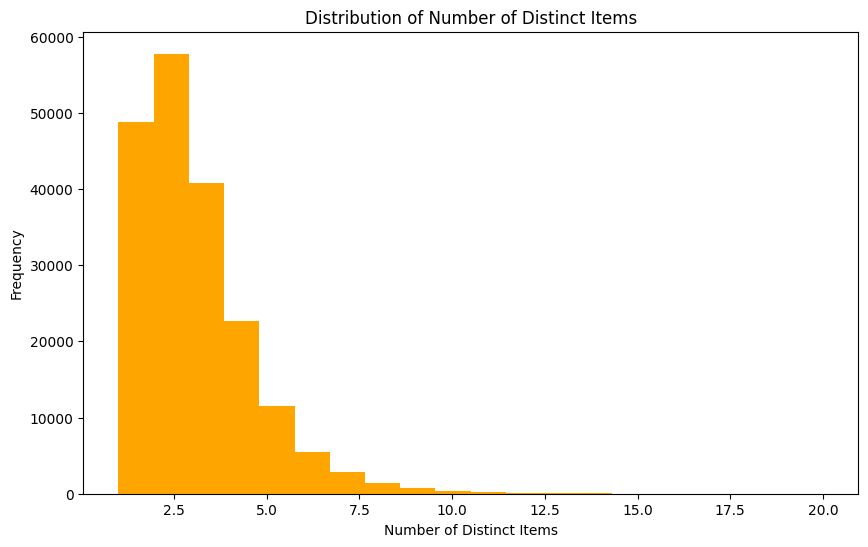

In [ ]:
# Histograms for num_distinct_items and total_items
plt.figure(figsize=(10, 6))
plt.hist(df['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.show()

We can also explore some scatter plots trying to study distinct vs delivery time

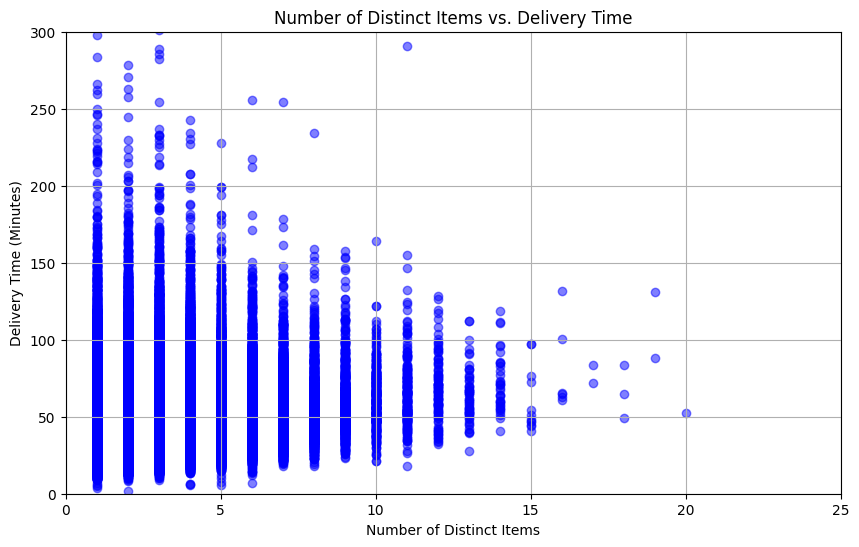

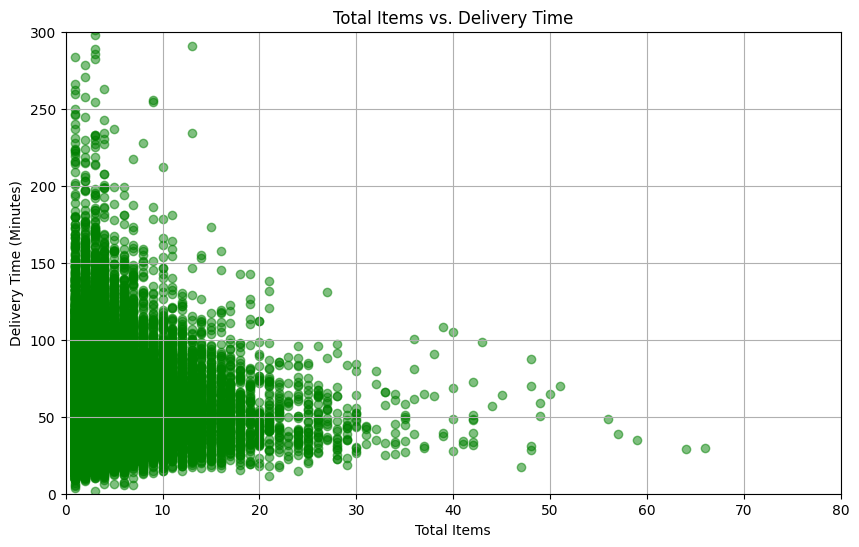

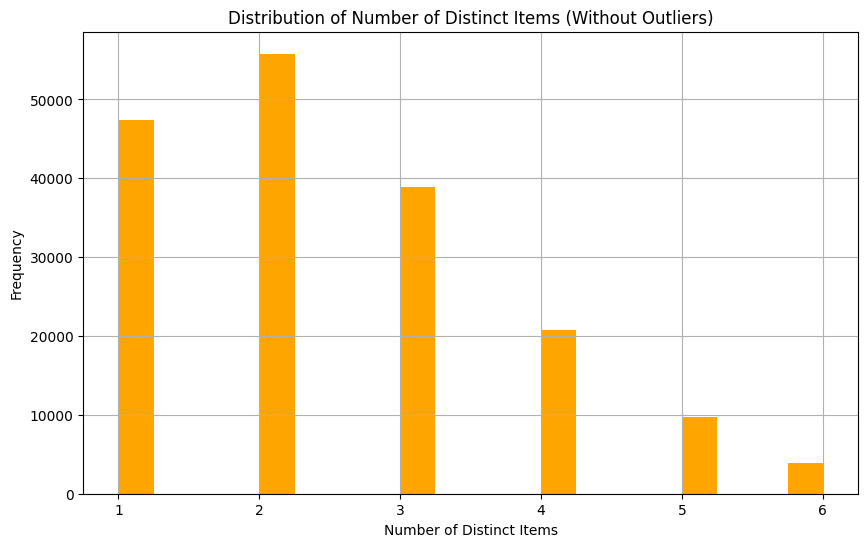

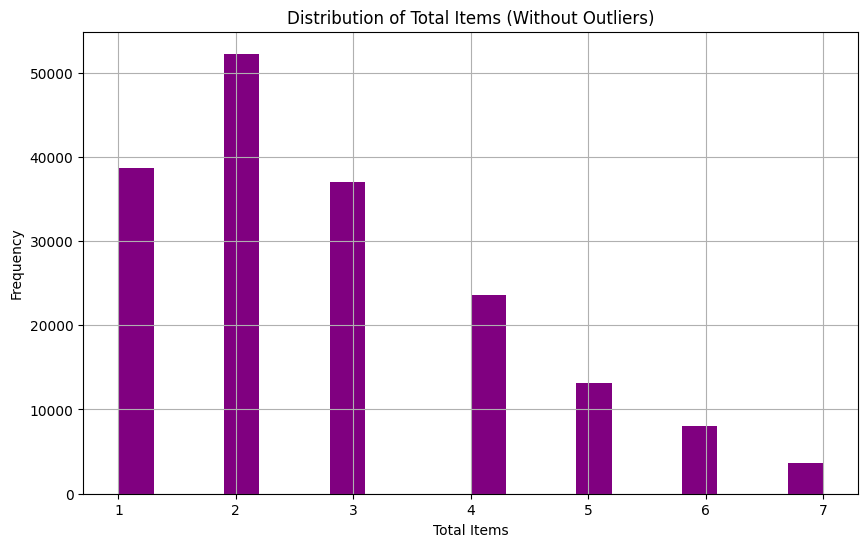

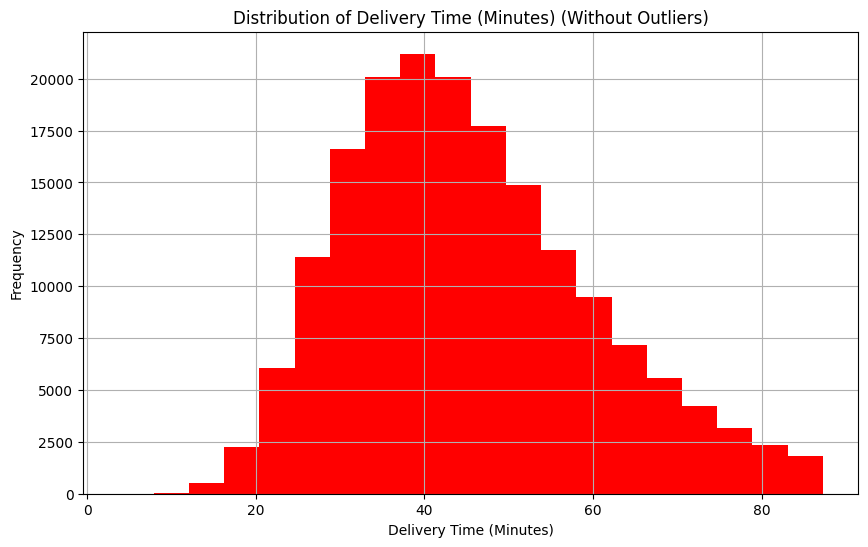

In [ ]:
# Scatter plot: num_distinct_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['num_distinct_items'], df['delivery_time_minutes'], alpha=0.5, color='blue')
plt.title('Number of Distinct Items vs. Delivery Time')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Delivery Time (Minutes)')
plt.grid(True)
plt.xlim(0,25)
plt.ylim(0,300)
plt.show()

# Scatter plot: total_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['total_items'], df['delivery_time_minutes'], alpha=0.5, color='green')
plt.title('Total Items vs. Delivery Time')
plt.xlabel('Total Items')
plt.ylabel('Delivery Time (Minutes)')
plt.xlim(0,80)
plt.ylim(0,300)
plt.grid(True)
plt.show()

# Remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for num_distinct_items, total_items, and delivery_time_minutes
df_filtered = df.copy()
df_filtered = remove_outliers(df_filtered, 'num_distinct_items')
df_filtered = remove_outliers(df_filtered, 'total_items')
df_filtered = remove_outliers(df_filtered, 'delivery_time_minutes')

# Histograms for num_distinct_items and total_items without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items (Without Outliers)')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['total_items'], bins=20, color='purple')
plt.title('Distribution of Total Items (Without Outliers)')
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for delivery_time_minutes without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['delivery_time_minutes'], bins=20, color='red')
plt.title('Distribution of Delivery Time (Minutes) (Without Outliers)')
plt.xlabel('Delivery Time (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Missing Values:
 market_id                                         495
store_id                                            0
store_primary_category                              0
order_protocol                                    488
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           15717
total_busy_dashers                              15717
total_outstanding_orders                        15717
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      515
delivery_time_minutes                               7
dtype: int64

Missing Value Proportion (%):
 market_id                                       0.256919
store_id                                        0.000000
store_primary_

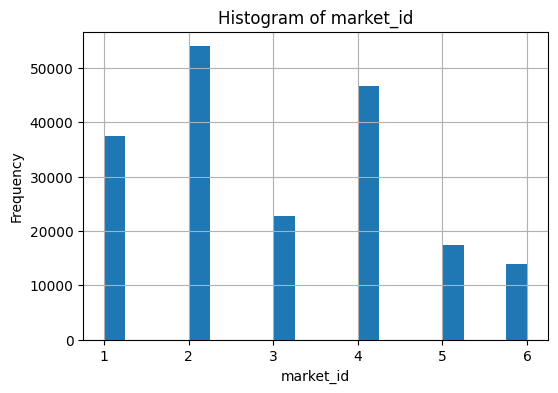

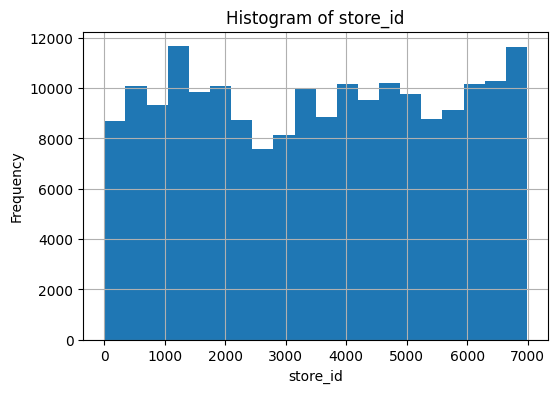

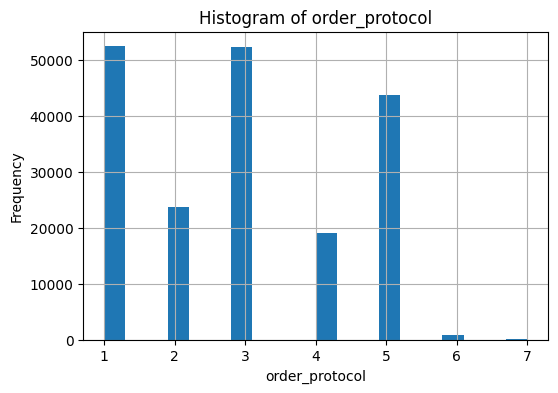

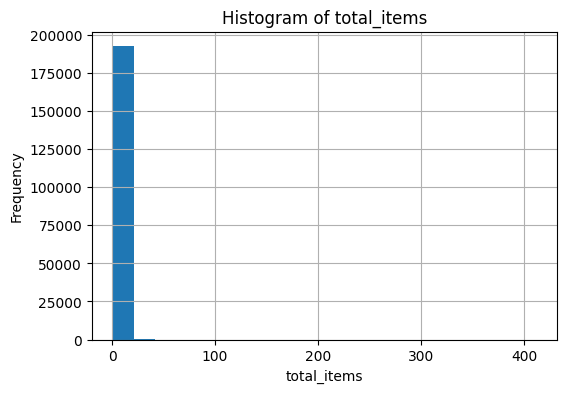

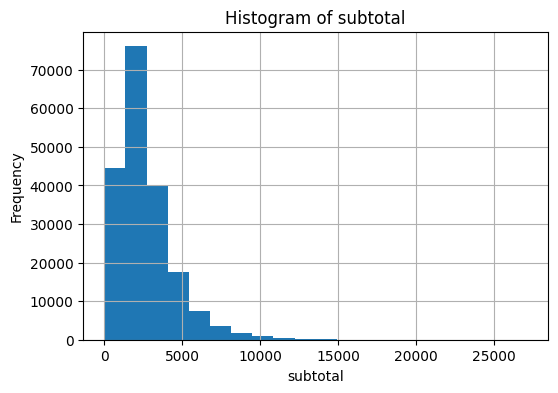

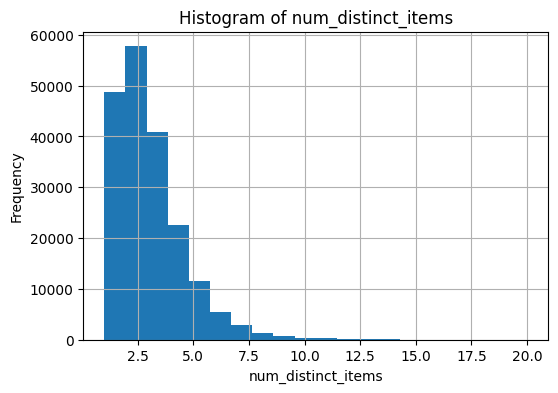

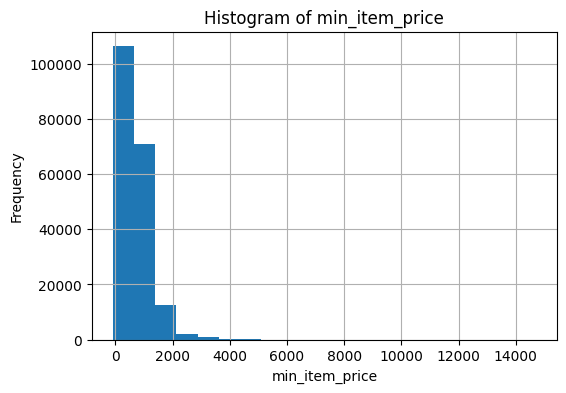

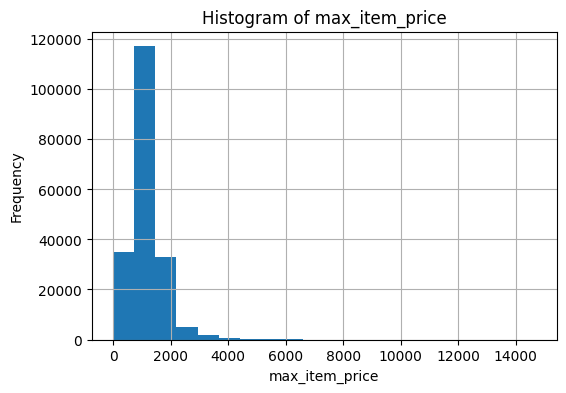

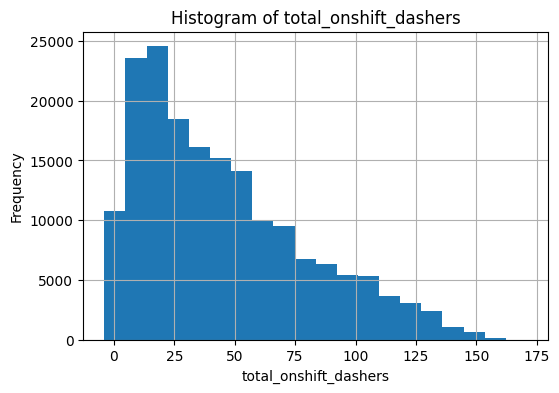

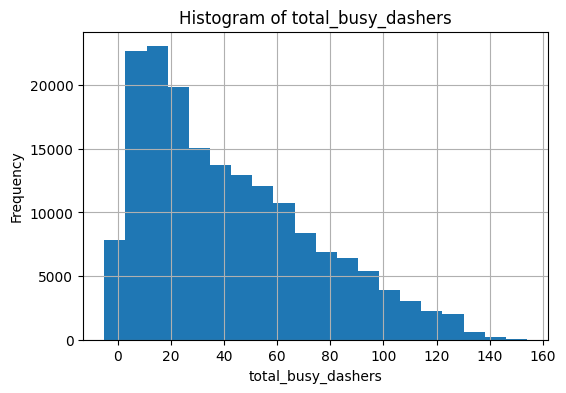

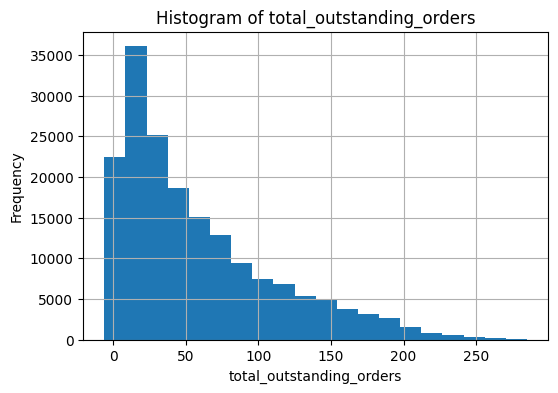

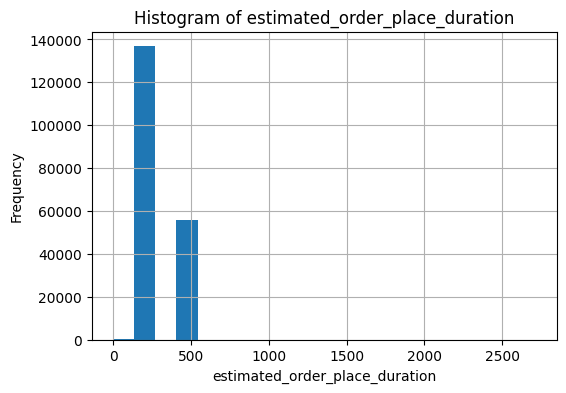

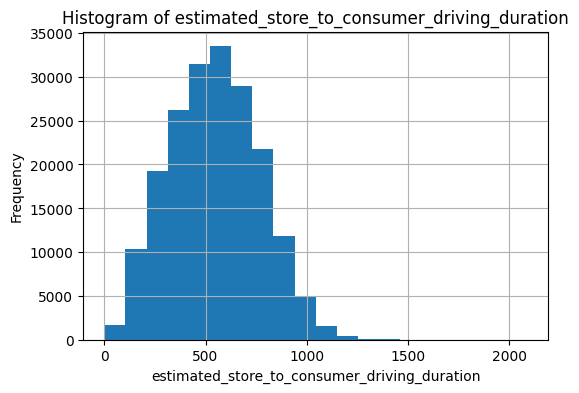

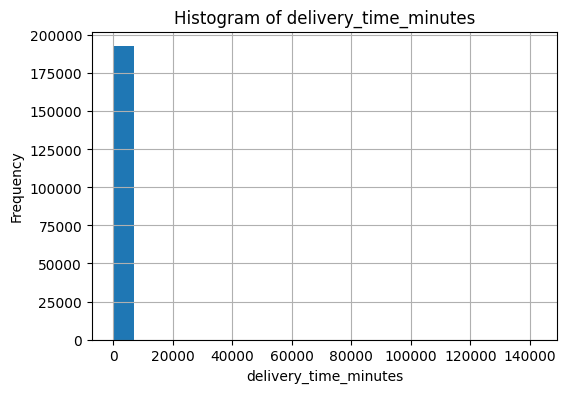

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

missing_proportion = df.isnull().mean() * 100
print("\nMissing Value Proportion (%):\n", missing_proportion)

for column in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{column}':\n", df[column].unique())
    if df[column].isnull().any():
        print(f"\nMissing values in '{column}': {df[column].isnull().sum()}")
        print(df[column].value_counts(dropna=False))  # Includes NaN count

for column in df.select_dtypes(include=np.number).columns:
  print(f"\nRange for '{column}': [{df[column].min()}, {df[column].max()}]")

for column in df.select_dtypes(include=np.number).columns:
  plt.figure(figsize=(6, 4))
  plt.hist(df[column].dropna(), bins=20)
  plt.title(f"Histogram of {column}")
  plt.xlabel(column)
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()

#Check-in #2

For the continuous response variable, we picked `delivery_time` as our metric, and we'll use some of the already described in our analysis above in order to assess it.

More specifically, we will be using `total_items, num_distinct_items, total_onshift_dashers, and total_busy_dashers`, as the predictor variables in the regression analysis.

To begin with, we split the dataset into training data and testing data using `sklearn.model_selection`


In [ ]:
from sklearn.model_selection import train_test_split

# Defining the feature variables and target variable
X = df_filtered[['total_items', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers']]
y = df_filtered['delivery_time_minutes']

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 141072
Validation set size: 35269


Now we can start with a Linear Regression model using a function in-built into `sklearn.linear_model`


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# the below code helps remove all NaN values from the data set
print(X_train.isnull().sum())
print(y_train.isnull().sum())

X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())

# Drop rows in y_train and y_val with missing values
y_train = y_train.dropna()
y_val = y_val.dropna()

# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on training and validation data
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calculate evaluation metrics
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training MSE: {train_mse:.2f}, Validation MSE: {val_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}, Validation R^2: {val_r2:.2f}")



total_items                  0
num_distinct_items           0
total_onshift_dashers    11407
total_busy_dashers       11407
dtype: int64
0
Training MSE: 204.23, Validation MSE: 204.62
Training R^2: 0.04, Validation R^2: 0.04


In [ ]:
from sklearn.linear_model import Ridge

# Initialize and fit Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You can experiment with different alpha values
ridge_model.fit(X_train, y_train)

# Predict on training and validation data
y_train_ridge_pred = ridge_model.predict(X_train)
y_val_ridge_pred = ridge_model.predict(X_val)

# Calculate evaluation metrics for Ridge model
train_ridge_mse = mean_squared_error(y_train, y_train_ridge_pred)
val_ridge_mse = mean_squared_error(y_val, y_val_ridge_pred)
train_ridge_r2 = r2_score(y_train, y_train_ridge_pred)
val_ridge_r2 = r2_score(y_val, y_val_ridge_pred)

print(f"Ridge - Training MSE: {train_ridge_mse:.2f}, Validation MSE: {val_ridge_mse:.2f}")
print(f"Ridge - Training R^2: {train_ridge_r2:.2f}, Validation R^2: {val_ridge_r2:.2f}")


Ridge - Training MSE: 204.23, Validation MSE: 204.62
Ridge - Training R^2: 0.04, Validation R^2: 0.04


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


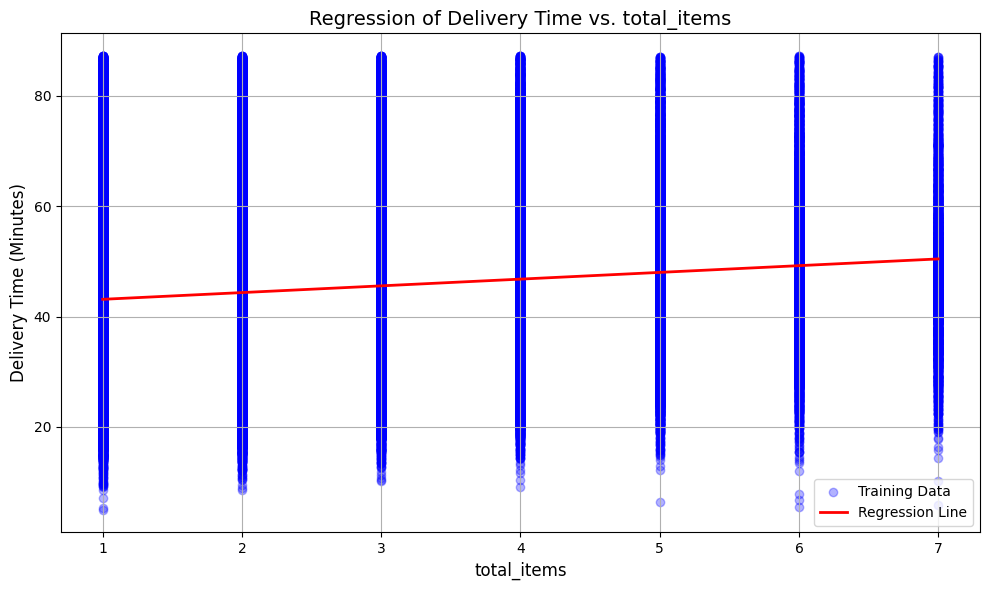

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


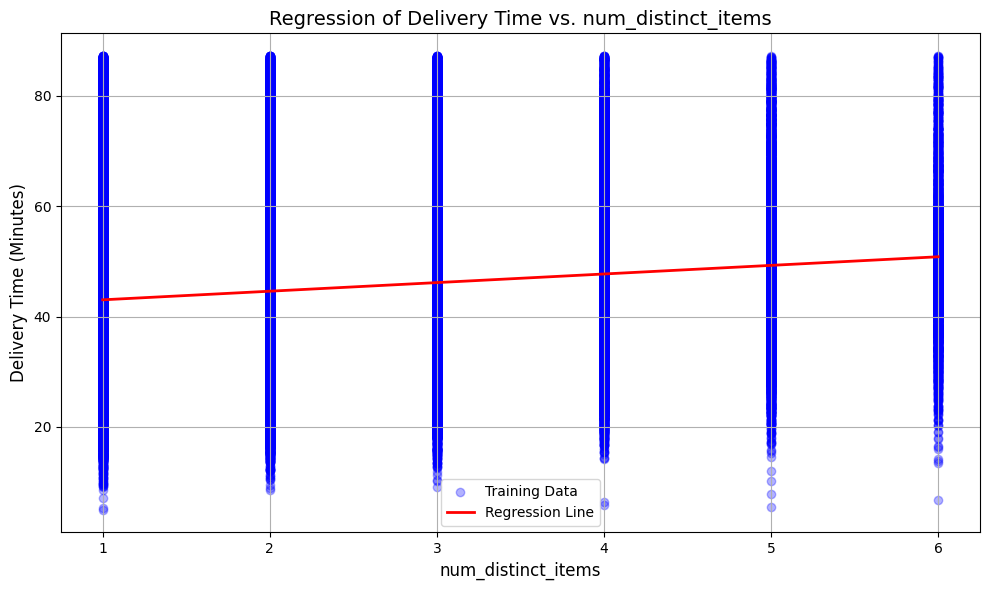

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


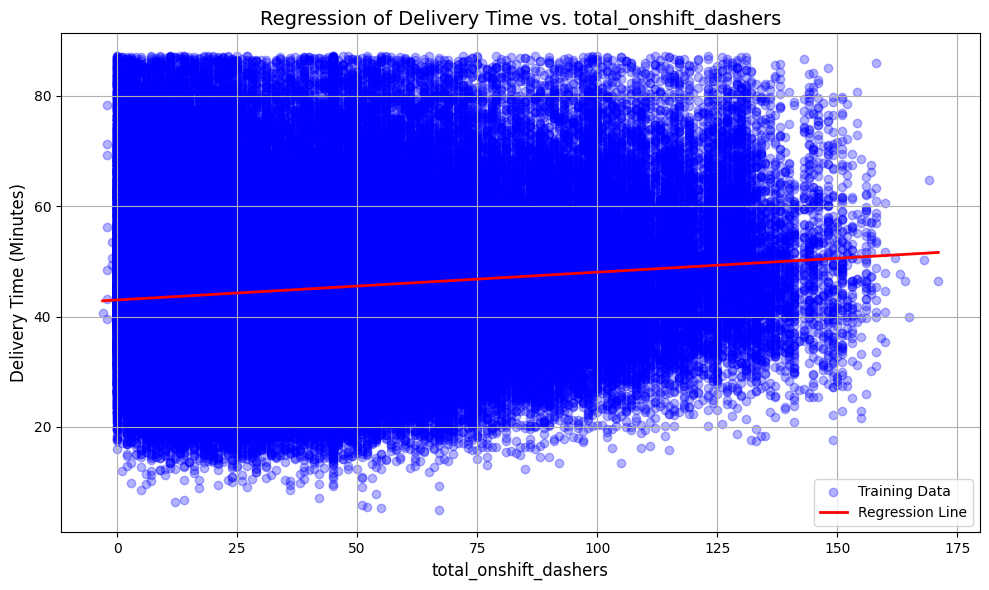

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


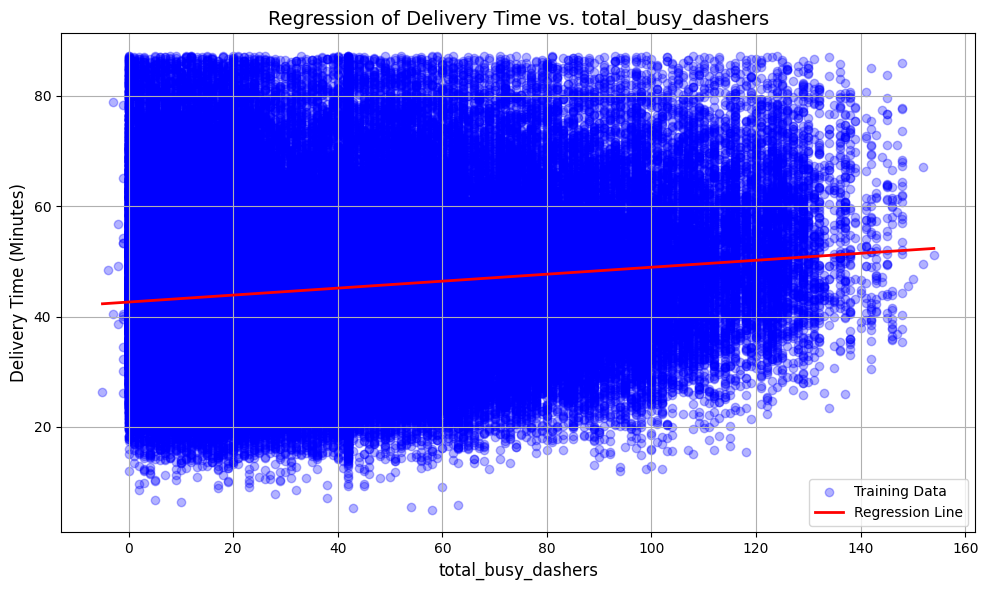

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Function to plot regression for each individual feature
def plot_single_feature_regression(X, y, feature_name):
    X_feature = X[[feature_name]]  # Extract only the feature for regression

    # Train a new model on just this feature
    single_feature_model = LinearRegression()
    single_feature_model.fit(X_feature, y)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Scatter plot
    plt.scatter(X[feature_name], y, color='blue', alpha=0.3, label='Training Data')

    # Creating a smooth range of values for plotting the regression line
    x_range = np.linspace(X[feature_name].min(), X[feature_name].max(), 100).reshape(-1, 1)

    # Predict y values for the regression line
    y_range_pred = single_feature_model.predict(x_range)

    # Plot the regression line
    plt.plot(x_range, y_range_pred, color='red', linewidth=2, label='Regression Line')

    # Titles and labels
    plt.title(f'Regression of Delivery Time vs. {feature_name}', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Delivery Time (Minutes)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Now plot for each feature individually
plot_single_feature_regression(X_train, y_train, 'total_items')
plot_single_feature_regression(X_train, y_train, 'num_distinct_items')
plot_single_feature_regression(X_train, y_train, 'total_onshift_dashers')
plot_single_feature_regression(X_train, y_train, 'total_busy_dashers')


#Check-in #3

Now for Check-in #3, we were tasked with using logistic regression.

**Question 1**
1. For the data set you have chosen choose any binary categorical response variable to model for logistic
regression. (This does not have to be directly related to the final goal of your project.)

For our response categorical variable, we will look at the data of deliveries with delivery_time under 50 minutes, and then further look at if the delivery took under 30 minutes or over 30 minutes within this range. So first we will organise our DF to only contain these values then OHC our response variable.

**Question 2**
2. Choose a single variable or variables to use as predictors.

We will use a form of multilinear regression, but instead of the raw variables we will instead use some calculated ones such as ratio of busy to onshift dashers.

All this organisational work is done in the cell below.


In [ ]:
data = df.copy()
data

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
14,1.0,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,37.883333
15,1.0,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,49.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0,65.116667
197424,1.0,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0,56.383333
197425,1.0,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0,50.133333
197426,1.0,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0,65.116667


In [ ]:
# Drop rows with delivery time more than 50 minutes
df_filtered = data[data['delivery_time_minutes'] <= 50]

# Drop specified columns
columns_to_drop = ['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration', 'min_item_price', 'max_item_price', 'market_id', 'store_id', 'store_primary_category', 'order_protocol']
df_filtered = df_filtered.drop(columns=columns_to_drop)

# Now df_filtered contains the modified DataFrame
df_filtered = df_filtered.reset_index(drop = True)
df_filtered

,total_items,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_time_minutes
0,4,4771,3,8.0,6.0,18.0,26.433333
1,1,1525,1,5.0,6.0,8.0,37.883333
2,2,3620,2,5.0,5.0,7.0,49.800000
3,5,1285,3,12.0,13.0,11.0,28.883333
4,4,5800,4,19.0,19.0,30.0,47.183333
...,...,...,...,...,...,...,...
122223,1,437,1,36.0,26.0,27.0,36.716667
122224,2,1297,2,5.0,6.0,7.0,22.566667
122225,1,669,1,56.0,45.0,45.0,28.866667
122226,7,2445,3,23.0,24.0,24.0,39.400000


In [ ]:
# Create a new column for how busy the other dashers are (with percent units)
df_filtered['Busyness Percentage'] = (df_filtered['total_busy_dashers'] / df_filtered['total_onshift_dashers'])

# Create a new df without features we aren't using directly
new_df = df_filtered.drop(['total_busy_dashers', 'total_onshift_dashers'], axis=1)

# Just organising the columns a bit better
new_df = new_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders', 'delivery_time_minutes']]


In [ ]:
# Remove any infinite values from the busyness column
final_df = new_df[~new_df['Busyness Percentage'].isin([np.inf, -np.inf])]

In [ ]:
# Create a new categorical variable based on delivery time where if its >= 30 minutes, it's = 1, otherwise its 0
final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)

# Now 'delivery_time_binary' has a 1 for delivery times >= 30 and 0 for < 30
cleaned_df = final_df.dropna()
cleaned_df

<ipython-input-22-a00227cfc6ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)


,total_items,num_distinct_items,Busyness Percentage,subtotal,total_outstanding_orders,delivery_time_minutes,delivery_time_binary
0,4,3,0.750000,4771,18.0,26.433333,0
1,1,1,1.200000,1525,8.0,37.883333,1
2,2,2,1.000000,3620,7.0,49.800000,1
3,5,3,1.083333,1285,11.0,28.883333,0
4,4,4,1.000000,5800,30.0,47.183333,1
...,...,...,...,...,...,...,...
122223,1,1,0.722222,437,27.0,36.716667,1
122224,2,2,1.200000,1297,7.0,22.566667,0
122225,1,1,0.803571,669,45.0,28.866667,0
122226,7,3,1.043478,2445,24.0,39.400000,1


In [ ]:
# Define predictor and response variables
X = cleaned_df[['total_items', 'num_distinct_items', 'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logreg model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the training data
y_pred = logreg_model.predict(X_train)

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate prediction accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Prediction Accuracy:", accuracy)

# Calculate true positive rate (sensitivity or recall)
tpr = recall_score(y_train, y_pred)
print("True Positive Rate (Recall):", tpr)

# Calculate true negative rate (specificity)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)
print("True Negative Rate (Specificity):", tnr)

# Ratio between positive and negative datapoints

Confusion Matrix:
 [[    3 18263]
 [    6 70061]]
Prediction Accuracy: 0.7931803516239684
True Positive Rate (Recall): 0.9999143676766523
True Negative Rate (Specificity): 0.000164239570787255


**Question_3**
3. Model your logistic regression and calculate the confusion matrix, prediction accuracy, predication
error, true positive rate, and true negative rate on your training data set.

This is shown in the cell above

Cross-Validation AUC: 0.6620826396425735
Cross-Validation Accuracy: 0.7931803516239684


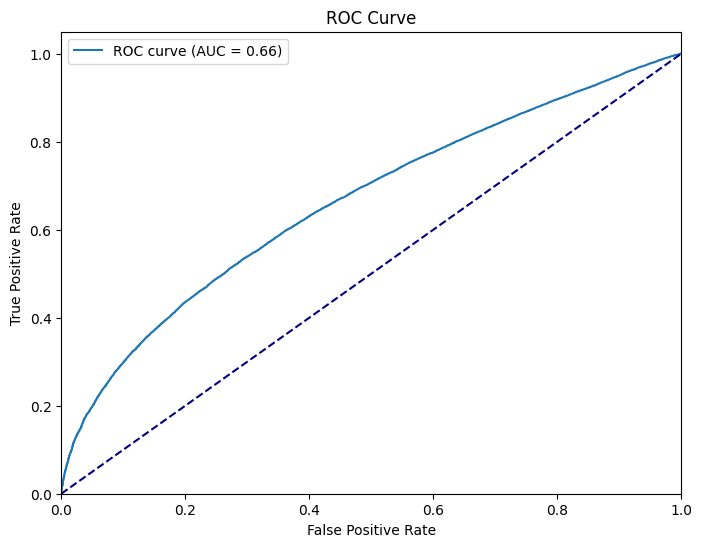

In [ ]:
# Define the model
logreg_model = LogisticRegression()

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)
y_pred_proba = cross_val_predict(logreg_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred = cross_val_predict(logreg_model, X_train, y_train, cv=cv)

# Calculate and print AUC and accuracy for each fold
auc = roc_auc_score(y_train, y_pred_proba)
accuracy = accuracy_score(y_train, y_pred)

print(f"Cross-Validation AUC: {auc}")
print(f"Cross-Validation Accuracy: {accuracy}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Question 4**

4. Calculate and plot the ROC curve and AUC on your validation data set. Use 5-fold cross-validation
on the validation set to calculate the AUC and accuracy of each fold

This can be shown above

**Question 5**
5. How did you choose a threshold for positive predictions?

As shown below, while the optimal threshold for which we would maximise the difference between TPR and FPR is about 0.8, it only gives us an accuracy of 56%. Whereas, if we set a custom threshold to slightly lower at 0.7, it gives us a much higher accuracy while still maintaining a decent gap between the TPR and FPR.

In [ ]:
# Calculate the optimal threshold by maximizing the difference between TPR and FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Calculate accuracy for the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
accuracy_optimal = accuracy_score(y_train, y_pred_optimal)
print(f"Accuracy for Optimal Threshold: {accuracy_optimal}")

custom_threshold = 0.7
print(f"\nCustom Threshold: {custom_threshold}")
y_pred_optimal = (y_pred_proba >= custom_threshold).astype(int)

# Calculate accuracy for the optimal threshold
accuracy_custom = accuracy_score(y_train, y_pred_optimal)
print(f"Accuracy for Custom Threshold: {accuracy_custom}")


Optimal Threshold: 0.8025680614131624
Accuracy for Optimal Threshold: 0.5566096475835758

Custom Threshold: 0.7
Accuracy for Custom Threshold: 0.7281650119434413


## Check in 4
Apply the KNN algorithm or Random Forest Algorithm for classification.

**Question 1**
1. For the data set you have chosen and the binary categorical response variable that you had chosen
for Check-In 3 for a logistic regression or another binary variable in your data set, apply the KNN
algorithm or Random Forest Algorithm for classification.(The variable chosen does not have to be
directly related to the final goal of your project.)

We continue to use the 'delivery_time_binary' as the categorical response variable. This is the the data of deliveries with delivery_time under 50 minutes, and then further if the delivery took under 30 minutes or over 30 minutes within this range. We used KNN with 3 neighbors to prevent underfitting and overfitting of the data. We can also experiment with a different number of neighbors later on to determine which one will yield the best results. Additionally, we scaled the data before fitting the model. This is because. scaling ensures all features contribute equally to distance computations and prevents features with large magnitudes dominating weightages.

In [ ]:
# 1. For the data set you have chosen and the binary categorical response variable that you had chosen
# For Check-In 3 for a logistic regression or another binary variable in your data set, apply the KNN
# algorithm or Random Forest Algorithm for classification.(The variable chosen does not have to be
# directly related to the final goal of your project.)

#As previously defined:
# X = cleaned_df[['total_items', 'num_distinct_items', 'subtotal', 'total_outstanding_orders']]
# y = cleaned_df['delivery_time_binary']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 3) # n_neighbors = k
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_train_scaled)

**Question 2**
2. Calculate the confusion matrix, prediction accuracy, prediction error, true positive rate, and true
negative rate, and F1 score on your training data set.

Much of this code is similar to the metrics from the previous checkin. We also added the calculation of the F1 score using the sklearn library.

In [ ]:
# 2. Calculate the confusion matrix, prediction accuracy, prediction error, true positive rate, and true negative rate, and F1 score on your training data set.

# Calculate the confusion matrix
cm= confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate prediction accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Prediction Accuracy:", accuracy)

# Calculate true positive rate (sensitivity or recall)
tpr = recall_score(y_train, y_pred)
print("True Positive Rate (Recall):", tpr)

# Calculate true negative rate (specificity)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)
print("True Negative Rate (Specificity):", tnr)

# Calculate F1 score
f1 = f1_score(y_train, y_pred)
print("F1 Score:", f1)


Confusion Matrix:
 [[ 7855 10411]
 [ 3546 66521]]
Prediction Accuracy: 0.8419956301721894
True Positive Rate (Recall): 0.9493912969015371
True Negative Rate (Specificity): 0.43003394284462937
F1 Score: 0.9050537758760264


[1 1 1 ... 1 1 1]
Cross-Validation AUC: 0.662082720121143
Cross-Validation Accuracy: 0.7931803516239684


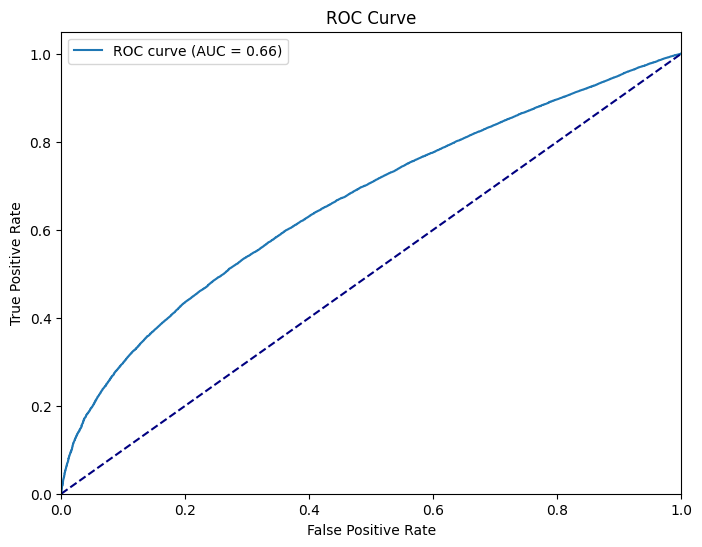

In [ ]:
# 3. Calculate and plot the ROC curve and AUC on your validation data set. Use 5-fold cross-validation on the validation set to calculate the AUC and accuracy of each fold.

# Define the model
knn = KNeighborsClassifier(n_neighbors = 3)

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)
y_pred_proba = cross_val_predict(logreg_model, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred = cross_val_predict(logreg_model, X_train_scaled, y_train, cv=cv)
print(y_pred)

# Calculate and print AUC and accuracy for each fold
auc = roc_auc_score(y_train, y_pred_proba)
accuracy = accuracy_score(y_train, y_pred)

print(f"Cross-Validation AUC: {auc}")
print(f"Cross-Validation Accuracy: {accuracy}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**bold text**# Check in 5

Applying the PCA unsupervised learning method to our data set

In the code snippet below, we have the script that performs the PCA on our dataset. To help analyze the results we also have a scree plot and cumulative variability explained, and how PCA is used for reduction. PCA is ideal since we have numerous features in our dataset.

We use Principal Component Analysis (PCA) to simplify the data by reducing its dimensions while keeping as much variability as possible. This is really helpful when working with high-dimensional datasets, like ours. PCA transforms the data into a new set of uncorrelated variables (principal components), ranked by their importance in explaining the variance from the original dataset. This helps us to learn the structure of the data by identifying patterns and relationships between different variables/features while also reducing noise.

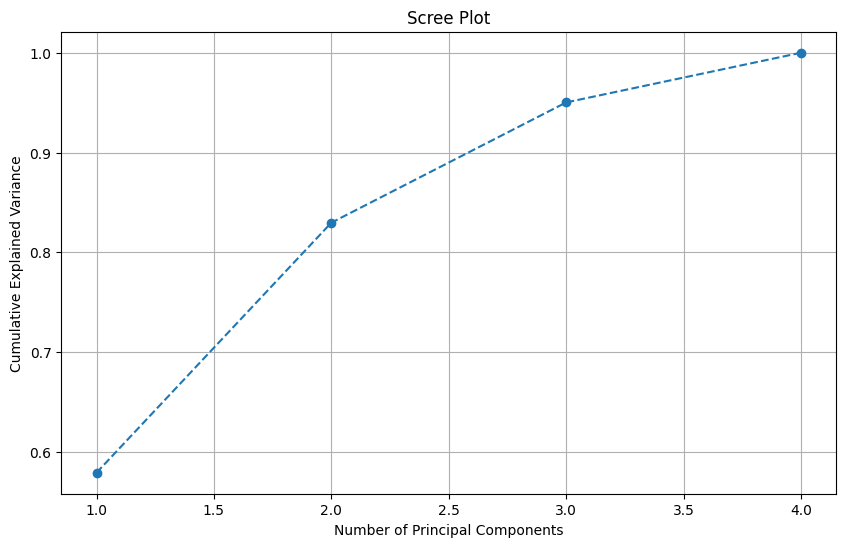

Number of components explaining 95% of variance: 3
Shape of the reduced data: (110417, 3)


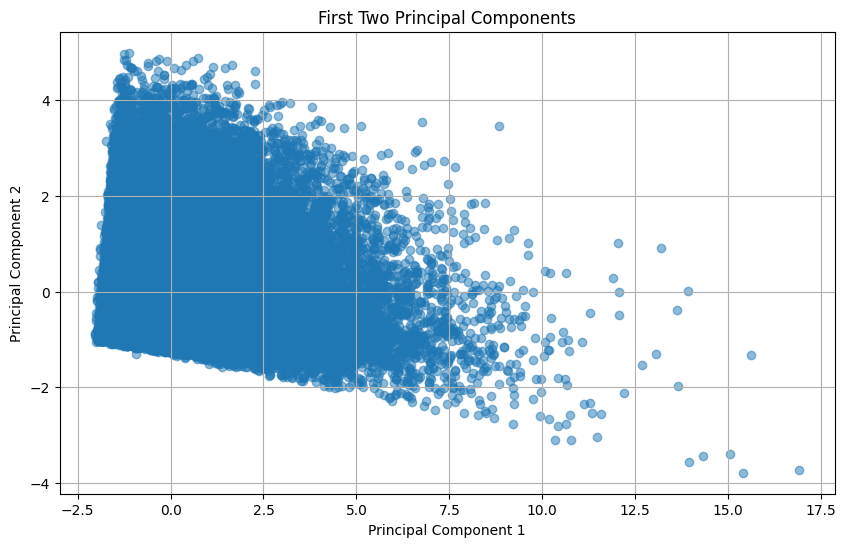

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# scaling the data X (used feature) and transforms it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Using the predictors from logistic regression or KNN

# fits pca model to scaled data and transforms into principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# scree plot code
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# printing no. of components that contriburte to 95% of var
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components_95}")

# transforms data using those components
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(X_scaled)

print(f"Shape of the reduced data: {X_reduced.shape}")

# scatter plot to visualize first two components
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.title('First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



**Explanation For Scree Plot:**

Based on the shape of this scree plot, the cumulative explained variance shows a steep increase for the first two principal components, reaching over 90% of the variance with the first two components alone. This suggests that most of the dataset's variance can be captured with only two components, making it suitable for dimensionality reduction without significant loss of information. Adding further components beyond this is basically diminishing returns for us as the variance only increases marginally.

**Explaination for Scatter Plot:**

In this scatter plot of the first two principal components, we observe that the data points form a dense cluster on the left side with a gradual spread toward the right. This pattern suggests that most of the variance is concentrated in a relatively narrow range, with a subset of points showing more distinct variability along Principal Component 1.

The clustering of data points very densely suggests that a lot of observations share similar characteristics within these first two PCs. However, when we go further along the x-axis we notice that a handful of these points are getting more spread out from the main dense cluseter. These represenet samples that differ way more from the majority, hinting at anomalies or unique patterns. So, we can tell that there is a central structure in the dataset, with a few outliers or unusual cases on the edges.





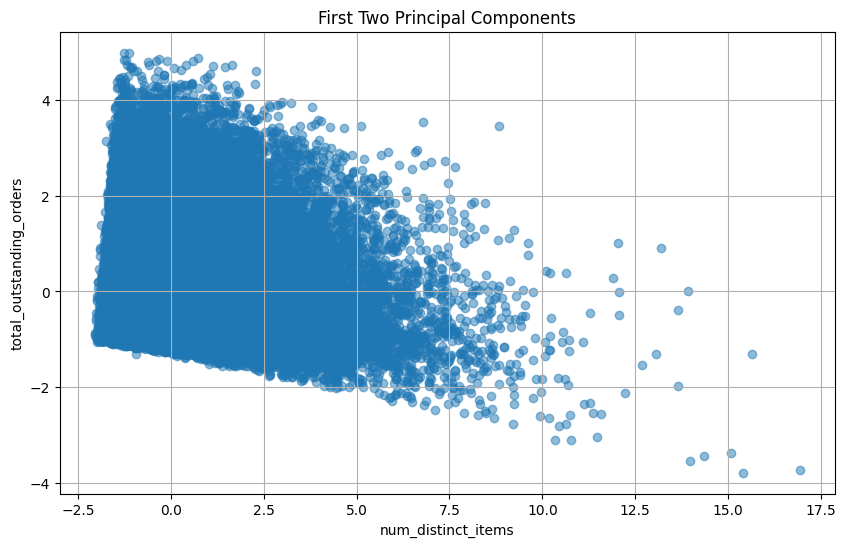

In [ ]:
# Creating a scatter plot for the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.title('First Two Principal Components')
plt.xlabel(X.columns[np.argmax(np.abs(pca.components_[0]))])
plt.ylabel(X.columns[np.argmax(np.abs(pca.components_[1]))])
plt.grid(True)
plt.show()

## **Check In 6**

Here we just used a multi-layer NN to predict delivery time based on features used previously such as total_items, num_distinct_items, and busyness percentage.

Testing learning rate: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 106682.0391 - val_loss: 1260.2203
Testing learning rate: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 17228.5273 - val_loss: 323.4335
Testing learning rate: 0.0025


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 16394.9062 - val_loss: 260.3614
Testing learning rate: 0.005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7225.5278 - val_loss: 176.3766
Testing learning rate: 0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8750.6846 - val_loss: 191.8338


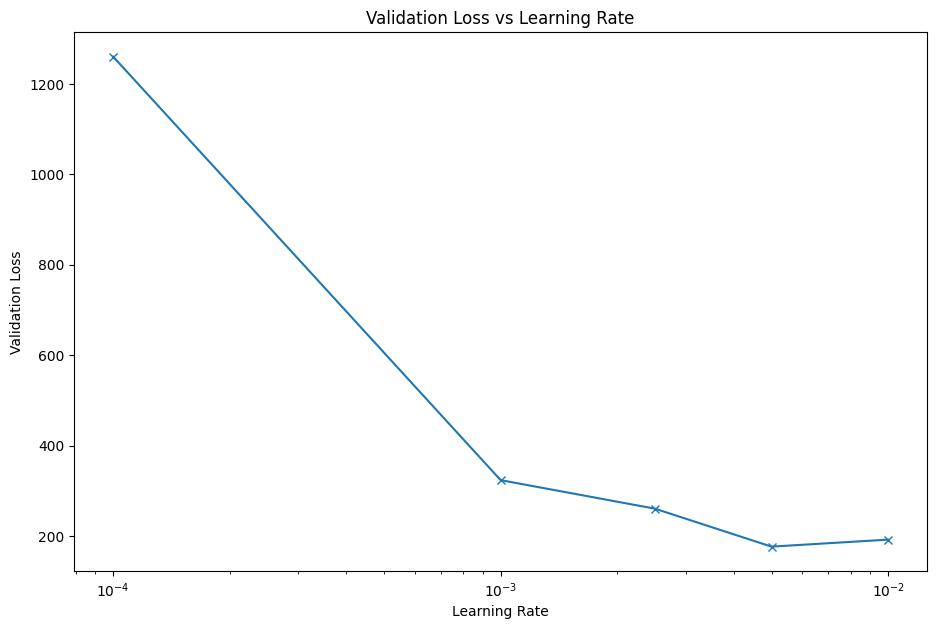

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# Learning rates to test
learning_rates = [0.0001, 0.001, 0.0025, 0.005, 0.01]

losses = []

# NN with relu activations for hidden layers
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Regression output
    ])
    return model

# Testing learning rates
for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    model = create_model()
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Train for 1 epoch
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=32,
        verbose=1
    )

    # Record the final validation loss
    final_loss = history.history['val_loss'][-1]
    losses.append(final_loss)

# Plot the losses for different learning rates
plt.figure(figsize=(11, 7))
plt.plot(learning_rates, losses, marker='x')
plt.xscale('log')  # Log scale for learning rates
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Learning Rate')
plt.show()

# Metric
We used Mean Squared Error, Mean Absolute Error, and the R-2 score for observing how the model is doing, but in terms of actually fitting the model and analysing learning rates, we only used MSE to heavily penalize large errors in delivery times as the scale of delivery times isn't that high in the first place ranging from 10 minutes to 60 minutes.

# Training Process

First we normalize the data, then fit the model on that for 12 epochs (discretionary decision) and then after re-scale to calculate performance metrics and analyse the training process based on the MSE loss function.

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.9335 - mae: 0.7965 - val_loss: 0.9083 - val_mae: 0.7874
Epoch 2/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9097 - mae: 0.7858 - val_loss: 0.9037 - val_mae: 0.7843
Epoch 3/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9020 - mae: 0.7833 - val_loss: 0.9001 - val_mae: 0.7842
Epoch 4/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9144 - mae: 0.7892 - val_loss: 0.9004 - val_mae: 0.7841
Epoch 5/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9074 - mae: 0.7867 - val_loss: 0.9045 - val_mae: 0.7877
Epoch 6/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.9082 - mae: 0.7860 - val_loss: 0.9021 - val_mae: 0.7849
Epoch 7/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9079 - mae: 0.7857 - val_loss: 0.9020 - val_mae: 0.7851
Epoch 8/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9086 - mae: 0.7851 - val_loss: 0.9015 - val_mae: 0.7823
Epoch 9/12
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/s

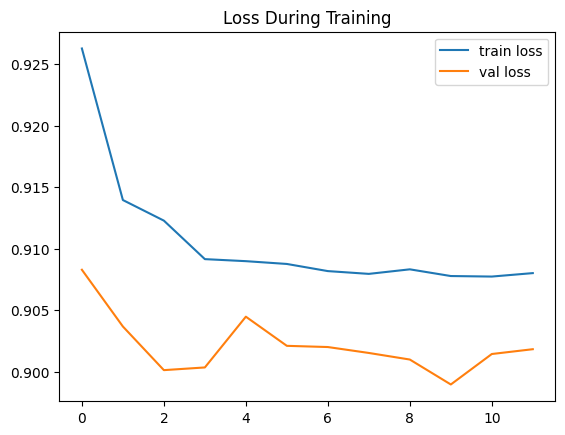

In [ ]:
# Organizing X and y
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage',  'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_minutes']

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=21)

# Normalizing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# NN configuration
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Single output for regression
])

model.compile(optimizer=Adam(learning_rate=0.002),
              loss='mse',
              metrics=['mae'])

# Training
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=32,
                    verbose=1)

# Evaluating NN
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Performance Metrics to check
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# For visualization
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

As for our learning rate, we referenced the method talked about in class where you choose 1/2 * maximal_LR which is the maximum LR for when validation loss starts to diverge, which we saw in the previous code segment. After selecting this LR, the NN was trained over 12 epochs, and as shown in the graph above we saw the val loss decrease sharply during the first 3 epochs then start to plateau.